<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/Chicago_Clear_LST_vs_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0
!pip install rasterio
!pip install rasterstats

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 12 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-underscore all 1.8.3~dfsg-1 [59.9 kB]
Get:4 htt

In [14]:
# Import necessary packages
import os, os.path
from glob import glob
from shutil import copyfile
import pickle
import requests

import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterstats import zonal_stats
from fiona.crs import from_epsg

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from matplotlib import colors as colors
import seaborn as sns



# Retrieve and process Chicago census tract information 

## From the Chicago data portal

* Boundaries - Census Tracts - 2010: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik

## From the Census API

General description of the Census Planning Database: https://www.census.gov/topics/research/guidance/planning-databases.2019.html
* Total population: https://api.census.gov/data/2019/pdb/tract/variables/Tot_Population_ACS_13_17.json
* Median household income variable: https://api.census.gov/data/2019/pdb/tract/variables/Med_HHD_Inc_ACS_13_17.json
* The percentage of people classified as below the poverty level in the ACS: https://api.census.gov/data/2019/pdb/tract/variables/pct_Prs_Blw_Pov_Lev_ACS_13_17.json
* Other available variables: https://api.census.gov/data/2019/pdb/tract/variables.html

In [27]:
# From the Chicago data portal
chi_tract = gpd.read_file('https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=GeoJSON', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)
chi_tract.info()                   
#chi_tract.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   statefp10   801 non-null    object  
 1   name10      801 non-null    object  
 2   commarea_n  801 non-null    object  
 3   namelsad10  801 non-null    object  
 4   commarea    801 non-null    object  
 5   geoid10     801 non-null    object  
 6   notes       801 non-null    object  
 7   tractce10   801 non-null    object  
 8   countyfp10  801 non-null    object  
 9   geometry    801 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 62.7+ KB


In [17]:
# From the Census API
# note that this link retrieves the Cook county tracts (not only Chicago)
census_json = requests.get("https://api.census.gov/data/2019/pdb/tract" + 
                         "?get=Tot_Population_ACS_13_17,Med_HHD_Inc_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17" + 
                         "&for=tract:*&in=state:17%20county:031").json()

In [21]:
tract_info_tmp = pd.DataFrame(columns = census_json[0], data = census_json[1:])
tract_info_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Tot_Population_ACS_13_17       1319 non-null   object
 1   Med_HHD_Inc_ACS_13_17          1313 non-null   object
 2   pct_Prs_Blw_Pov_Lev_ACS_13_17  1315 non-null   object
 3   state                          1319 non-null   object
 4   county                         1319 non-null   object
 5   tract                          1319 non-null   object
dtypes: object(6)
memory usage: 62.0+ KB


In [22]:
tract_info_tmp.head()

,Tot_Population_ACS_13_17,Med_HHD_Inc_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,state,county,tract
0,4444,"$33,750",36.76,17,031,010100
1,7197,"$40,841",33.22,17,031,010201
2,2487,"$36,563",17.46,17,031,010202
3,6413,"$36,870",18.61,17,031,010300
4,5411,"$39,634",18.76,17,031,010400


In [25]:
# correct the data types
tract_info_tmp['geoid10'] = tract_info_tmp['state'] + tract_info_tmp['county'] + tract_info_tmp['tract']

tract_info_tmp['pop'] = tract_info_tmp['Tot_Population_ACS_13_17'].astype(int)
tract_info_tmp['log_pop'] = np.log10(tract_info_tmp['pop'])

tract_info_tmp['hhd_inc'] = tract_info_tmp['Med_HHD_Inc_ACS_13_17'].replace('[\$,]', '', regex=True).astype(float)
tract_info_tmp['log_inc'] = np.log10(tract_info_tmp['hhd_inc'])

tract_info_tmp['pcnt_blw_pov'] = tract_info_tmp['pct_Prs_Blw_Pov_Lev_ACS_13_17'].astype(float)

tract_info = tract_info_tmp[['geoid10', 'pop', 'log_pop', 'hhd_inc', 'log_inc', 'pcnt_blw_pov']].dropna()
tract_info.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,geoid10,pop,log_pop,hhd_inc,log_inc,pcnt_blw_pov
0,17031010100,4444,3.647774,33750.0,4.528274,36.76
1,17031010201,7197,3.857152,40841.0,4.611096,33.22
2,17031010202,2487,3.395676,36563.0,4.563042,17.46
3,17031010300,6413,3.807061,36870.0,4.566673,18.61
4,17031010400,5411,3.733278,39634.0,4.598068,18.76


In [26]:
# merge the geometries with information
chi_tract = pd.merge(chi_tract[['geoid10', 'geometry']], tract_info, how='inner', left_on='geoid10', right_on='geoid10')
chi_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 796 entries, 0 to 795
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geoid10       796 non-null    object  
 1   geometry      796 non-null    geometry
 2   pop           796 non-null    int64   
 3   log_pop       796 non-null    float64 
 4   hhd_inc       796 non-null    float64 
 5   log_inc       796 non-null    float64 
 6   pcnt_blw_pov  796 non-null    float64 
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 49.8+ KB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
files = glob("drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/*.tif")
print(files)

['drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c23_MuSLI_Cloud_Chicago.201906072300.001.20201004233757.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c15_MuSLI_Cloud_Chicago.201906071500.001.20201004163116.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c13_MuSLI_Cloud_Chicago.201906071300.001.20201004144144.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c19_MuSLI_Cloud_Chicago.201906071900.001.20201004200221.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c22_MuSLI_Cloud_Chicago.201906072200.001.20201004224258.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c16_MuSLI_Cloud_Chicago.201906071600.001.20201004172527.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c17_MuSLI_Cloud_Chicago.201906071700.001.20201004182000.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c20_MuSLI_Cloud_Chicago.201906072000.001.20201004205006.tif', 'drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c18_MuSLI_Cloud_Chicago.201906071800.001.20201004191245.tif', 'drive/My Drive/SatTemp/SatTemp_Glyn

In [5]:
!rm -rf geotiff
if not os.path.exists('geotiff'):
  os.mkdir('geotiff')

In [6]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'geotiff/' + os.path.basename(f))

drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c23_MuSLI_Cloud_Chicago.201906072300.001.20201004233757.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c15_MuSLI_Cloud_Chicago.201906071500.001.20201004163116.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c13_MuSLI_Cloud_Chicago.201906071300.001.20201004144144.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c19_MuSLI_Cloud_Chicago.201906071900.001.20201004200221.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c22_MuSLI_Cloud_Chicago.201906072200.001.20201004224258.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c16_MuSLI_Cloud_Chicago.201906071600.001.20201004172527.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c17_MuSLI_Cloud_Chicago.201906071700.001.20201004182000.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c20_MuSLI_Cloud_Chicago.201906072000.001.20201004205006.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c18_MuSLI_Cloud_Chicago.201906071800.001.20201004191245.tif
drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/c12_MuSLI_Cloud_Chic

In [ ]:
# sorting will give us the files from June 1st 00 hour to June 3rd 23 hour
lst_files = glob("geotiff/*LST*.tif")
lst_files.sort()
print(lst_files)

cloud_files = glob("geotiff/*Cloud*.tif")
cloud_files.sort()
print(cloud_files)

all_files = glob("geotiff/*.tif")
all_files.sort()
print(all_files)

['geotiff/l00_MuSLI_LST_Chicago.201906080000.001.20201005003546.tif', 'geotiff/l01_MuSLI_LST_Chicago.201906080100.001.20201005013056.tif', 'geotiff/l02_MuSLI_LST_Chicago.201906080200.001.20201005022717.tif', 'geotiff/l03_MuSLI_LST_Chicago.201906080300.001.20201005031952.tif', 'geotiff/l04_MuSLI_LST_Chicago.201906080400.001.20201005041044.tif', 'geotiff/l05_MuSLI_LST_Chicago.201906080500.001.20201005051113.tif', 'geotiff/l06_MuSLI_LST_Chicago.201906080600.001.20201005061306.tif', 'geotiff/l07_MuSLI_LST_Chicago.201906080700.001.20201005071218.tif', 'geotiff/l08_MuSLI_LST_Chicago.201906080800.001.20201005081333.tif', 'geotiff/l09_MuSLI_LST_Chicago.201906080900.001.20201005091124.tif', 'geotiff/l10_MuSLI_LST_Chicago.201906081000.001.20201005100701.tif', 'geotiff/l11_MuSLI_LST_Chicago.201906081100.001.20201005110041.tif', 'geotiff/l12_MuSLI_LST_Chicago.201906071200.001.20201004135003.tif', 'geotiff/l13_MuSLI_LST_Chicago.201906071300.001.20201004144144.tif', 'geotiff/l14_MuSLI_LST_Chicago.20

In [ ]:
for file in lst_files[:3]:
  print(file.split('_'))
  print(file.split('_')[0].split('/')[1])
  #print(file.split('_')[1] + '_' + file.split('_')[2][14:16] + '-' + file.split('_')[2][16:18])
#lst_files[num].split('_')[3] + '_' + lst_files[num].split('_')[4]

for file in cloud_files[:3]:
  print(file.split('_'))
  print(file.split('_')[0].split('/')[1])
  #print(file.split('_')[1] + '_' + file.split('_')[2][14:16] + '-' + file.split('_')[2][16:18])


['geotiff/l00', 'MuSLI', 'LST', 'Chicago.201906080000.001.20201005003546.tif']
l00
['geotiff/l01', 'MuSLI', 'LST', 'Chicago.201906080100.001.20201005013056.tif']
l01
['geotiff/l02', 'MuSLI', 'LST', 'Chicago.201906080200.001.20201005022717.tif']
l02
['geotiff/c00', 'MuSLI', 'Cloud', 'Chicago.201906080000.001.20201005003546.tif']
c00
['geotiff/c01', 'MuSLI', 'Cloud', 'Chicago.201906080100.001.20201005013056.tif']
c01
['geotiff/c02', 'MuSLI', 'Cloud', 'Chicago.201906080200.001.20201005022717.tif']
c02


In [ ]:
boundary = {}
raster = {}
nodata = {}
src_crs = {}

for file in all_files:
  #key = file.split('_')[2] + '_' + file.split('_')[3]
  #key = file.split('_')[1] + '_' + file.split('_')[2][14:16] + '-' + file.split('_')[2][16:18]
  key = file.split('_')[0].split('/')[1]
  #print(key)
  with rio.open(file) as src:
    boundary[key] = src.bounds
    if 'LST' in file:
      raster[key] = src.read() - 273.15
    else:
      raster[key] = src.read()
    nodata[key] = src.nodata
    src_crs[key] = src.crs

print(raster.keys())

dict_keys(['c00', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'l00', 'l01', 'l02', 'l03', 'l04', 'l05', 'l06', 'l07', 'l08', 'l09', 'l10', 'l11', 'l12', 'l13', 'l14', 'l15', 'l16', 'l17', 'l18', 'l19', 'l20', 'l21', 'l22', 'l23'])


In [ ]:
prop_nan = {}

tmp_raster = raster['l00']
tmp_raster[raster['c00'] == 1] = np.nan
tmp_raster[raster['l00'] < 0] = np.nan
prop_nan['00'] = np.average(np.isnan(tmp_raster))

masked_raster = tmp_raster
print(masked_raster.shape)

for ii in range(1,24):
  # apply the cloud mask
  tmp_raster = raster['l' + str(ii).zfill(2)]
  tmp_raster[raster['c' + str(ii).zfill(2)] == 1] = np.nan
  tmp_raster[raster['l' + str(ii).zfill(2)] < 0] = np.nan
  prop_nan[str(ii).zfill(2)] = np.average(np.isnan(tmp_raster))
  # concatenate to make the timed LST from 00 hour to 23 hour
  masked_raster = np.concatenate((masked_raster, tmp_raster), axis=0)

print(masked_raster.shape)

(1, 685, 952)
(24, 685, 952)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [ ]:
prop_nan

{'00': 0.0,
 '01': 0.0,
 '02': 0.0,
 '03': 0.0,
 '04': 0.0,
 '05': 0.0,
 '06': 0.0,
 '07': 0.0,
 '08': 0.0,
 '09': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.008102803165061645,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.039896031405262836,
 '17': 0.04063055879286021,
 '18': 0.025578114457461817,
 '19': 0.02799791449426486,
 '20': 0.0028614365454210883,
 '21': 0.0,
 '22': 0.0026360179108139608,
 '23': 0.015397472857756242}

In [ ]:
# UTC -> CST time convert
# 6 hours differences, so that 
# 19 hour -> 13 hour (1 PM)

masked_raster_CST = np.concatenate((masked_raster[6:], masked_raster[:6]), axis=0)
print(masked_raster_CST.shape)

(24, 685, 952)


In [ ]:
# create a wide-form pandas
masked_raster_df = pd.DataFrame()
for ii in range(24):
  masked_raster_df[ii] = masked_raster[ii].flatten()

for ii in range(24):
  masked_raster_df[24+ii] = masked_raster_CST[ii].flatten()

#masked_raster_df.info()

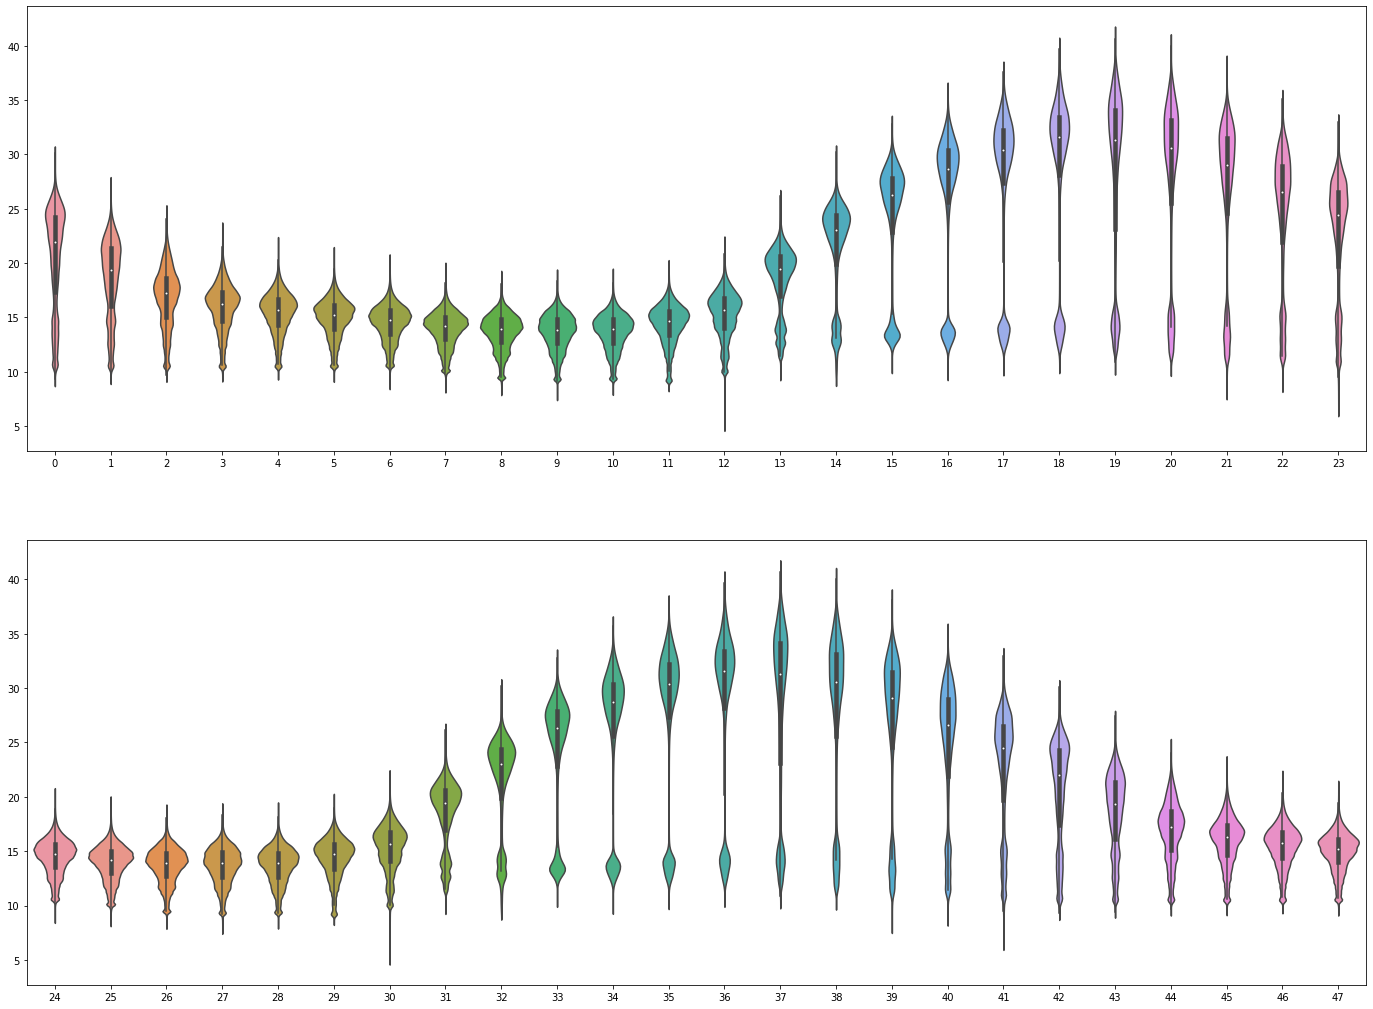

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(24,18))

sns.violinplot(data=masked_raster_df.iloc[:,0:24], ax=axs[0])
sns.violinplot(data=masked_raster_df.iloc[:,24:48], ax=axs[1])

In [ ]:
# save the processed geotiff file

geo_data = {}
geo_data['lst_files'] = lst_files
geo_data['cloud_files'] = cloud_files
geo_data['boundary'] = boundary
geo_data['src_crs'] = src_crs
geo_data['lst_raster'] = masked_raster

datafile = open('drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/processed.pkl', 'wb')
pickle.dump(geo_data, datafile)                      
datafile.close()

In [ ]:
#boundary['l00']
masked_raster[0].shape


(685, 952)

In [ ]:
raster_shape = masked_raster[0].shape
raster_bound = boundary['l00']

uchicago_loc = [41.7886, -87.5987] # lat, lng

def coord_to_raster(coord, bound, shape):
  slope_lat = (bound[3] - bound[1]) / shape[0]
  slope_lng = (bound[2] - bound[0]) / shape[1]

  rst_lat = round((bound[3] - coord[0]) / slope_lat) # lat
  rst_lng = round((coord[1] - bound[0]) / slope_lng) # lng
  
  print(coord, ' : (', rst_lat, ',', rst_lng, ')')
  return (rst_lat, rst_lng)

coord_to_raster([raster_bound[1],raster_bound[0]], raster_bound, raster_shape)

coord_to_raster([raster_bound[1],raster_bound[2]], raster_bound, raster_shape)

coord_to_raster([raster_bound[3],raster_bound[0]], raster_bound, raster_shape)

coord_to_raster([raster_bound[3],raster_bound[2]], raster_bound, raster_shape)

coord_to_raster(uchicago_loc, raster_bound, raster_shape)

[41.46612652341049, -88.26368408376308]  : ( 685 , 0 )
[41.46612652341049, -87.31312550993508]  : ( 685 , 952 )
[42.14968408376307, -88.26368408376308]  : ( 0 , 0 )
[42.14968408376307, -87.31312550993508]  : ( 0 , 952 )
[41.7886, -87.5987]  : ( 362 , 666 )


(362, 666)

In [ ]:
def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.85)

uchicago_loc = [41.7886, -87.5987]
bounds = [[boundary['c00'].bottom, boundary['c00'].left], [boundary['c00'].top, boundary['c00'].right]],

# Create a map using the Map() function and the coordinates for Chicago, IL
m = folium.Map(location=uchicago_loc, 
               tiles='Stamen Terrain', 
               zoom_start=14)

# best LST maps
# Check the previous weather here: https://www.timeanddate.com/weather/usa/chicago/historic?month=6&year=2019
# '07-15'
# '11-14'

curr_map = masked_raster_CST[12]

curr_map[361:364, 665:668] = 0
curr_map[362, 666] = 50

# adjust the color map
import branca.colormap as cm
tmin = 15 #np.floor(np.nanmin(masked_raster[key]))
tmax = 40 #np.ceil(np.nanmax(masked_raster[key]))
tmp_color = cm.linear.RdBu_11.colors.copy()
#tmp_color = cm.linear.Greys_09.colors
tmp_color.reverse()
colormap = cm.LinearColormap(
    colors = tmp_color, 
    vmin = tmin, 
    vmax = tmax)
print('Colormap range: ', tmin, tmax)

# overlay the raster
folium.raster_layers.ImageOverlay(
    image = curr_map,
    opacity = 0.7,
    pixelated = True,
    bounds = bounds,
    colormap= lambda value: mapvalue2color(value, colormap)
).add_to(m)

folium.Marker(uchicago_loc, popup='UChicago').add_to(m)

folium.LayerControl().add_to(m)
colormap.caption = 'MuSLI_LST'
m.add_child(colormap)

m


Colormap range:  15 40
